### 1. Objective

In this notebook, we train classification models to predict credit risk (default vs no default), evaluate them using appropriate metrics, and calibrate the predicted probabilities for better reliability in decision-making.


In [1]:
import pandas as pd
import numpy as np
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    roc_auc_score, accuracy_score, brier_score_loss,
    classification_report, confusion_matrix,
    RocCurveDisplay, ConfusionMatrixDisplay
)

### 2. Load Preprocessed Data

We load the processed training and test data, as well as the labels, from the previous preprocessing notebook.


In [3]:
# Recarregar si ho fas des un altre notebook
X_train_processed = joblib.load("../models/X_train_processed.pkl") if "X_train_processed" not in locals() else X_train_processed
X_test_processed = joblib.load("../models/X_test_processed.pkl") if "X_test_processed" not in locals() else X_test_processed
y_train = joblib.load("../models/y_train.pkl") if "y_train" not in locals() else y_train
y_test = joblib.load("../models/y_test.pkl") if "y_test" not in locals() else y_test


### 3. Train Baseline Logistic Regression

We start with a logistic regression model as a baseline. We evaluate both its classification performance and the calibration of its predicted probabilities.


In [9]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_processed, y_train)
y_pred = logreg.predict(X_test_processed)
y_proba = logreg.predict_proba(X_test_processed)[:, 1]
joblib.dump(logreg, "../models/logreg.pkl")


['../models/logreg.pkl']

### 4. Evaluate Model Performance

We evaluate the model using classification metrics, AUC-ROC, and Brier Score. These help us assess both the discriminative power and the calibration of the model.


Accuracy: 0.78
AUC-ROC: 0.8040476190476191
Brier Score: 0.15497100880525008

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85       140
           1       0.67      0.53      0.59        60

    accuracy                           0.78       200
   macro avg       0.74      0.71      0.72       200
weighted avg       0.77      0.78      0.77       200



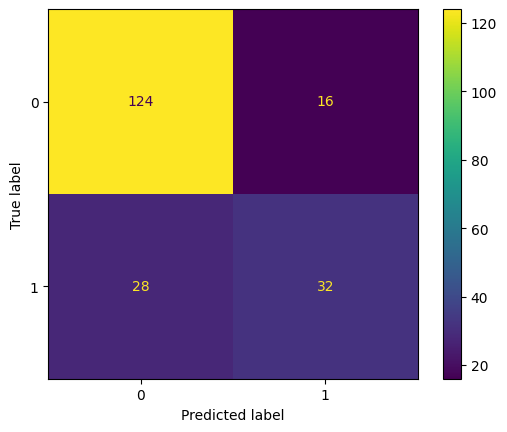

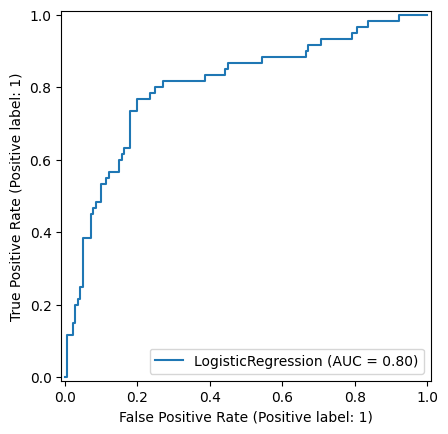

In [5]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))
print("Brier Score:", brier_score_loss(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

# ROC curve
RocCurveDisplay.from_estimator(logreg, X_test_processed, y_test)


### 5. Calibrate the Model

We apply Platt scaling (logistic calibration) using `CalibratedClassifierCV` to improve probability reliability. Calibration is particularly important in credit scoring, where we want accurate probability estimates, not just class predictions.


Brier Score (Calibrated): 0.1562102107697662


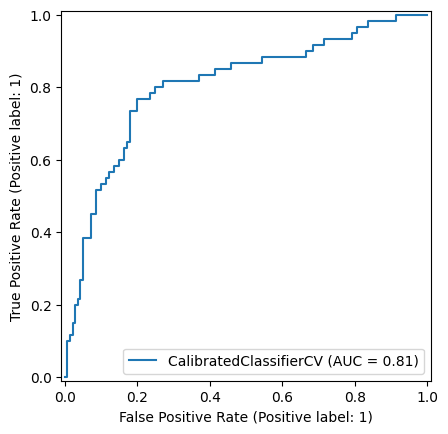

In [6]:
calibrated_model = CalibratedClassifierCV(logreg, method='sigmoid', cv=5)
calibrated_model.fit(X_train_processed, y_train)

y_calibrated_proba = calibrated_model.predict_proba(X_test_processed)[:, 1]
print("Brier Score (Calibrated):", brier_score_loss(y_test, y_calibrated_proba))

# Optional: ROC of calibrated model
RocCurveDisplay.from_estimator(calibrated_model, X_test_processed, y_test)


### 6. Train a Random Forest Classifier

We now train a more powerful model (Random Forest) and compare its performance to the baseline logistic regression.


AUC-ROC (RF): 0.7792857142857142
Brier Score (RF): 0.166693


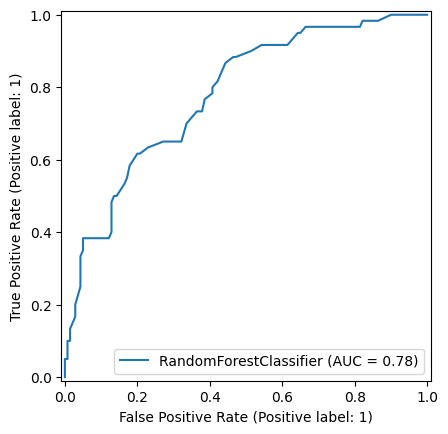

In [7]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_processed, y_train)
rf_proba = rf.predict_proba(X_test_processed)[:, 1]

print("AUC-ROC (RF):", roc_auc_score(y_test, rf_proba))
print("Brier Score (RF):", brier_score_loss(y_test, rf_proba))

RocCurveDisplay.from_estimator(rf, X_test_processed, y_test)


### 7. Summary of Model Comparison

We summarize the performance of each model in terms of both classification power (AUC) and calibration (Brier Score). This will help select the best model for explainability and business deployment.


In [8]:
summary = pd.DataFrame({
    "Model": ["Logistic Regression", "Logistic Calibrated", "Random Forest"],
    "AUC-ROC": [
        roc_auc_score(y_test, y_proba),
        roc_auc_score(y_test, y_calibrated_proba),
        roc_auc_score(y_test, rf_proba)
    ],
    "Brier Score": [
        brier_score_loss(y_test, y_proba),
        brier_score_loss(y_test, y_calibrated_proba),
        brier_score_loss(y_test, rf_proba)
    ]
})

summary


,Model,AUC-ROC,Brier Score
0,Logistic Regression,0.804048,0.154971
1,Logistic Calibrated,0.805000,0.156210
2,Random Forest,0.779286,0.166693


### 8. Conclusions

Based on our evaluation:

- **Logistic Regression** offers the best balance between discrimination (AUC = 0.804) and calibration (Brier = 0.155).
- **Calibrated Logistic Regression** slightly improves AUC (0.805) but slightly worsens Brier Score.
- **Random Forest** performs worse than logistic models in both AUC and calibration, likely due to uncalibrated probability outputs.

For a real-world deployment in financial services, where probability reliability and model interpretability are key, **Logistic Regression with or without calibration would be the preferred choice**.

Next, we will use SHAP to explain model predictions and identify the most influential features.
